# Context
In my previous notebook, I showed you how to read a Git repository directly in Python with GitPython. As much as I like that approach (because everything is in one place and therefore reproducible), it's (currently) very slow while reading all the statistics information.

# The idea
What I want to have now is a really fast method to read in a complete Git repository. So we are taking a shortcut for retrieving the commit history by exporting it into a log file (which itself is pretty fast). You can use e. g.
<pre>
git log --all --numstat --pretty=format:'--%h--%ad--%aN' --no-renames > git.log 
</pre>
to do this. This will output a file with all the log information of a repository. In this example, we analyse the Git repository of [aim42](https://github.com/aim42/aim42) (an open book project about how to improve legacy systems). 

The first entries of that file look something like this:

In [1]:
with open (r'C:\dev\repos\aim42\git.log') as log:
    [print(line, end='') for line in log.readlines()[:8]]

--ea7e08b--Tue Nov 29 21:42:16 2016 +0100--feststelltaste
2	0	src/main/asciidoc/appendices/bibliography.adoc
1	7	src/main/asciidoc/pattern-index.adoc
12	1	src/main/asciidoc/patterns/improve/anticorruption-layer.adoc

--fa1ca6f--Thu Dec 22 08:04:18 2016 +0100--feststelltaste
2	0	src/main/asciidoc/appendices/bibliography.adoc
2	2	src/main/asciidoc/patterns/analyze/busfactor.adoc


For each commit, there is a header line with the commit info. It contains the SHA key, the timestamp of the commit as well as the author's name. For each other row, we print some statitics about the modified files like the number of lines inserted, the number of lines deleted and the file path.

With a little trick and a little bit of data wrangling we can read that information into a nicely structured DataFrame. Let's get started!

# Import the data

First, I'll show you my approach on how to read nearly everything into a DataFrame. The key is to use Pandas' <tt>read_csv</tt> for reading non-character separated values. How to do that? We simply choose a separator that doesn't occur in the file that we want to read. My favorite character for this is the "DEVICE CONTROL TWO" character U+0012. I haven't encountered a situation yet where this character was included in a data set.

We just read our <tt>git.log</tt> file without any headers (because there are none) and give the only column a nice name.

In [2]:
import pandas as pd

commits = pd.read_csv(r'C:\dev\repos\aim42\git.log', sep="\u0012", header=None, names=['raw'])
commits.head()

,raw
0,--ea7e08b--Tue Nov 29 21:42:16 2016 +0100--fes...
1,2\t0\tsrc/main/asciidoc/appendices/bibliograph...
2,1\t7\tsrc/main/asciidoc/pattern-index.adoc
3,12\t1\tsrc/main/asciidoc/patterns/improve/anti...
4,--fa1ca6f--Thu Dec 22 08:04:18 2016 +0100--fes...


# Data Wrangling

OK, but now we have a <strike>problem</strike> data wrangling challenge. We have the commit info as well as the statistic for the modified file in one column, but the don't belong together. What we want is to have the commit info along with the file statistics in separate columns to get some serious analysis started.

# Commit info
Ok, let's treat the commit info first. Luckily, we set in our git log export command some kind of anchor or marker to identify the commit info: Each commit info starts with an <tt>--</tt>. So let's extract all the commit infos from the original <tt>commits</tt> <tt>DataFrame</tt>.

In [3]:
commit_marker = commits[commits['raw'].str.startswith("--",na=False)]
commit_marker.head()

,raw
0,--ea7e08b--Tue Nov 29 21:42:16 2016 +0100--fes...
4,--fa1ca6f--Thu Dec 22 08:04:18 2016 +0100--fes...
7,--c3d4e2d--Thu Dec 22 05:47:32 2016 +0100--Dr....
8,--3f793e8--Tue Nov 29 21:42:16 2016 +0100--fes...
12,--5d297c9--Wed Dec 21 20:49:33 2016 +0100--fes...


With this, we can focus on extracting the information that is within a commit info row. The next command could be looking a little frightening, but don't worry. We want to extract some data from the <tt>raw</tt> column. For this, we use the <tt>extract</tt> method on the string representation (note the<tt> str</tt>) of the row. This method expects a regular expression. We gladly provide our own regex that works as follows:

* <tt>^</tt>: the beginning of the row
* <tt>--</tt>: the two dashes that are used in the git log file as separator between the entries
* <tt>(?P&lt;sha&gt;.*?)--</tt>: a named match group (marked by the <tt>(</tt> and <tt>)</tt> ) with the name <tt>sha</tt> for all characters (<tt>.&#42;</tt>) until the next occurrence (<tt>?</tt>) of the <tt>--</tt> separators.
* and so on until <tt>\$</tt> as the marker for the end of the row (actually, <tt>^</tt> and <tt>$</tt> aren't needed, but it looks nicer from a regex string's perspective in my eyes ;-) )

I use these ugly looking, named regex groups because then the name of such a group will be used by Pandas for the name of the column (therefore we save renaming the columns later on).

The <tt>expand=True</tt> keyword delivers a <tt>DataFrame</tt> with columns for each detected regex group.

We simply store the result into a new <tt>DataFrame</tt> variable.

In [4]:
commit_info = commit_marker['raw'].str.extract(
        r"^--(?P<sha>.*?)--(?P<date>.*?)--(?P<author>.*?)$", 
        expand=True)
commit_info['date'] = pd.to_datetime(commit_info['date'])
commit_info.head()

,sha,date,author
0,ea7e08b,2016-11-29 20:42:16,feststelltaste
4,fa1ca6f,2016-12-22 07:04:18,feststelltaste
7,c3d4e2d,2016-12-22 04:47:32,Dr. Gernot Starke
8,3f793e8,2016-11-29 20:42:16,feststelltaste
12,5d297c9,2016-12-21 19:49:33,feststelltaste


OK, this part is ready, let's have a look at the file statistics!

# File statistics

Every row that is not a commit info row is a file statistics row. So we just use the index from our already prepared commit info <tt>DataFrame</tt> to get the other data.

In [5]:
file_stats_marker = commits[~commits.index.isin(commit_info.index)]
file_stats_marker.head()

,raw
1,2\t0\tsrc/main/asciidoc/appendices/bibliograph...
2,1\t7\tsrc/main/asciidoc/pattern-index.adoc
3,12\t1\tsrc/main/asciidoc/patterns/improve/anti...
5,2\t0\tsrc/main/asciidoc/appendices/bibliograph...
6,2\t2\tsrc/main/asciidoc/patterns/analyze/busfa...


Luckily, the row's data is just a tab separated string that we can easily split with the <tt>split</tt> method. We expand the result to get a <tt>DataFrame</tt> and rename the default columns to something that make more sense.

In [6]:
file_stats = file_stats_marker['raw'].str.split("\t", expand=True)
file_stats = file_stats.rename(columns={0: "insertions", 1: "deletions", 2: "filename"})
file_stats['insertions'] = pd.to_numeric(file_stats['insertions'], errors='coerce')
file_stats['deletions'] = pd.to_numeric(file_stats['deletions'], errors='coerce')
file_stats.head()

,insertions,deletions,filename
1,2.0,0.0,src/main/asciidoc/appendices/bibliography.adoc
2,1.0,7.0,src/main/asciidoc/pattern-index.adoc
3,12.0,1.0,src/main/asciidoc/patterns/improve/anticorrupt...
5,2.0,0.0,src/main/asciidoc/appendices/bibliography.adoc
6,2.0,2.0,src/main/asciidoc/patterns/analyze/busfactor.adoc


# Putting it all together
Now we have three parts: all commits, the separated commit info and the file statitics.

For glueing it all together into a normalized <tt>DataFrame</tt>, we have to make some adjustments to the indexes.

For the commit info, we want to have each info for each file statitics row. That means, we reindex the commit info that it fits by using the index of the file statistics <tt>DataFrame</tt>. But if we would just do that, we don't get any data, because both <tt>DataFrame</tt>'s indexes overlap at all.

In [7]:
commit_info.reindex(file_stats.index).head()

,sha,date,author
1,NaN,NaT,NaN
2,NaN,NaT,NaN
3,NaN,NaT,NaN
5,NaN,NaT,NaN
6,NaN,NaT,NaN


Thus we need to reindex over the <tt>commits</tt>' index:

In [8]:
commit_info.reindex(commits.index).head(3)

,sha,date,author
0,ea7e08b,2016-11-29 20:42:16,feststelltaste
1,NaN,NaT,NaN
2,NaN,NaT,NaN


And fill the missing values for the file statistics' rows to get the needed structure. Together, this is done like the following:

In [9]:
commit_data = commit_info.reindex(commits.index).fillna(method="ffill")
commit_data.head()

,sha,date,author
0,ea7e08b,2016-11-29 20:42:16,feststelltaste
1,ea7e08b,2016-11-29 20:42:16,feststelltaste
2,ea7e08b,2016-11-29 20:42:16,feststelltaste
3,ea7e08b,2016-11-29 20:42:16,feststelltaste
4,fa1ca6f,2016-12-22 07:04:18,feststelltaste


After filling the file statitics rows, we can throw away the dedicated commit info rows by reusing the index from above.

In [10]:
commit_data = commit_data[~commit_data.index.isin(commit_info.index)]
commit_data.head()

,sha,date,author
1,ea7e08b,2016-11-29 20:42:16,feststelltaste
2,ea7e08b,2016-11-29 20:42:16,feststelltaste
3,ea7e08b,2016-11-29 20:42:16,feststelltaste
5,fa1ca6f,2016-12-22 07:04:18,feststelltaste
6,fa1ca6f,2016-12-22 07:04:18,feststelltaste


The easy step afterwards is to join the file statitics <tt>DataFrame</tt> with the <tt>commit_data</tt>.

In [11]:
commit_data = commit_data.join(file_stats)
commit_data.head()

,sha,date,author,insertions,deletions,filename
1,ea7e08b,2016-11-29 20:42:16,feststelltaste,2.0,0.0,src/main/asciidoc/appendices/bibliography.adoc
2,ea7e08b,2016-11-29 20:42:16,feststelltaste,1.0,7.0,src/main/asciidoc/pattern-index.adoc
3,ea7e08b,2016-11-29 20:42:16,feststelltaste,12.0,1.0,src/main/asciidoc/patterns/improve/anticorrupt...
5,fa1ca6f,2016-12-22 07:04:18,feststelltaste,2.0,0.0,src/main/asciidoc/appendices/bibliography.adoc
6,fa1ca6f,2016-12-22 07:04:18,feststelltaste,2.0,2.0,src/main/asciidoc/patterns/analyze/busfactor.adoc


We're done!

# Complete code block
To much code to look through? Here is everything from above in a condensed format.

In [12]:
%%time
import pandas as pd

commits = pd.read_csv(r'C:\dev\repos\aim42\git.log', sep="\u0012", header=None, names=['raw'])

commit_marker = commits[commits['raw'].str.startswith("--",na=False)]
commit_info = commit_marker['raw'].str.extract(
        r"^--(?P<sha>.*?)--(?P<date>.*?)--(?P<author>.*?)$", 
        expand=True)
commit_info['date'] = pd.to_datetime(commit_info['date'])

file_stats_marker = commits[~commits.index.isin(commit_info.index)]
file_stats = file_stats_marker['raw'].str.split("\t", expand=True)
file_stats = file_stats.rename(columns={0: "insertions", 1: "deletions", 2: "filename"})
file_stats['insertions'] = pd.to_numeric(file_stats['insertions'], errors='coerce')
file_stats['deletions'] = pd.to_numeric(file_stats['deletions'], errors='coerce')

commit_data = commit_info.reindex(commits.index).fillna(method="ffill")
commit_data = commit_data[~commit_data.index.isin(commit_info.index)]
commit_data = commit_data.dropna()
commit_data = commit_data.join(file_stats)

Wall time: 220 ms


Just some milliseconds to run through, not bad!

# Summary
In this notebook, I showed you how to read some non-perfect structure data via the non-character separator trick. I also showed you how to tranform the rows that contain multiple kinds of data into one nicely structured <tt>DataFrame</tt>.

Now that we have the Git repository <tt>DataFrame</tt>, we can do some nice things with it e. g. visualizing the code churn of a project, but that's a story for another notebook! But to give you a glimpse:

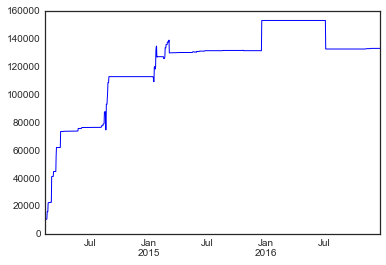

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
plot_data = commit_data.set_index(pd.DatetimeIndex(commit_data['date']))[['insertions', 'deletions']].resample('1D').sum()
plot_data = plot_data
plot_data['delta'] = plot_data['insertions'] - plot_data['deletions']
plot_data['churn'] = plot_data['delta'].cumsum().fillna(method='ffill')
plot_data['churn'].plot()

Stay tuned!